In [1]:
%pylab inline
import h5py

Populating the interactive namespace from numpy and matplotlib


In [2]:
f_train = h5py.File('train.h5','r')
f_test = h5py.File('test.h5','r')
print(f_train.keys())
print(f_test.keys())

[u'train']
[u'test']


In [3]:
a_train = f_train['train']
a_test = f_test['test']
print(a_train.keys())
print(a_test.keys())

[u'axis0', u'axis1', u'block0_items', u'block0_values', u'block1_items', u'block1_values']
[u'axis0', u'axis1', u'block0_items', u'block0_values']


In [4]:
b = a_train['block1_values']
b.shape

(45324, 1)

In [5]:
# axis0 -> Labels [shape (101,)]
# axis1 -> id column [shape (45324,)]
# block0_items -> traits labels [shape (100,)]
# block0_values -> traits values [shape (45324,100)]
# block1_items -> 'y' label
# block1_values -> y column (without label) [shape (45324,1)]

In [6]:
X_tr = a_train['block0_values'][()]
y_train = a_train['block1_values'][()]
y_train = y_train[:,0]
X_te = a_test['block0_values'][()]

In [7]:
#Preprocessing
#Shuffle
c = zip(y_train, X_tr)
random.shuffle(c)
y_train, X_tr = zip(*c)
y_train = asarray(y_train)
X_tr = asarray(X_tr)

In [8]:
X_tr, X_va = X_tr[:-5000], X_tr[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]
ids = a_test['axis1']

In [9]:
#Are there zero columns?
def is_zero_vector(x):
    count = 0
    for i in arange(len(x)):
        if x[i] == 0.:
            count += 1
    if count == len(x):
        return True
    return False

In [10]:
zero_i = list([])
for k in arange(len(X_tr[0,:])):   
    if is_zero_vector(X_tr[:,k]):
        zero_i.append(k)
X_tr = delete(X_tr, zero_i, 1)
X_va = delete(X_va, zero_i, 1)
X_te = delete(X_te, zero_i, 1)

In [11]:
print(X_tr.shape)
print(X_te.shape)
print(X_va.shape)

(40324, 90)
(8137, 90)
(5000, 90)


In [12]:
X_va -= np.mean(X_tr, axis = 0)
X_te -= np.mean(X_tr, axis = 0)
X_tr -= np.mean(X_tr, axis = 0)

X_va /= np.std(X_tr, axis = 0)
X_te /= np.std(X_tr, axis = 0)
X_tr /= np.std(X_tr, axis = 0)

#print(is_zero_vector(X_tr[:,4]))
#print(np.std(X_tr, axis = 0))
#print(X_tr[:,4])

In [13]:
X_train = X_tr
X_test = X_te
X_val = X_va

In [14]:
print(len(X_train[0,:]))
print(X_train[1,0])
print(X_train.shape)
print(type(X_train))

90
-0.101106
(40324, 90)
<type 'numpy.ndarray'>


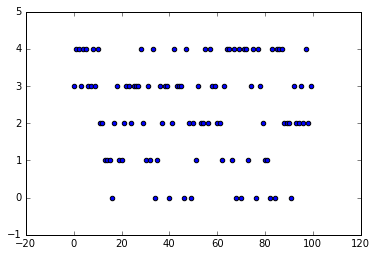

In [15]:
scatter(arange(100), y_train[0:100])

In [16]:
from theano import *
import theano.tensor as T
from __future__ import print_function
import time
import lasagne

In [17]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [55]:
def train_NN(num_epochs=500, width = 100, d_i = 0.3, d_h = 0.5, l_r = 0.01, la1p = 0.1, la2p = 0.1, la3p = 0.5):
    
    input_var = T.matrix('inputs')
    target_var = T.ivector('targets')
    
    print("Building model and compiling functions...")
    
    layer_in = lasagne.layers.InputLayer(shape=(None, 90), input_var=input_var)
    if d_i:
        layer_in = lasagne.layers.dropout(layer_in, p=d_i)
    
    # Hidden layers and dropout:
    
    nonlin = lasagne.nonlinearities.rectify
    layer1 = lasagne.layers.DenseLayer(layer_in, width, nonlinearity=nonlin)
    if d_h:
        layer1 = lasagne.layers.dropout(layer1, p=d_h)
        
    layer2 = lasagne.layers.DenseLayer(layer1, width, nonlinearity=nonlin)
    if d_h:
        layer2 = lasagne.layers.dropout(layer2, p=d_h)
        
    #layer3 = lasagne.layers.DenseLayer(layer2, width, nonlinearity=nonlin)
    #if d_h:
    #    layer3 = lasagne.layers.dropout(layer3, p=d_h)
        
    #layer4 = lasagne.layers.DenseLayer(layer3, width, nonlinearity=nonlin)
    #if d_h:
    #    layer4 = lasagne.layers.dropout(layer4, p=d_h)
        
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(layer2, 5, nonlinearity=softmax)
    
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    #layers = {layer1: la1p, layer2: la2p, network: la3p}
    #l2_penalty_1 = lasagne.regularization.regularize_layer_params_weighted({layer1:la1p}, lasagne.regularization.l2)
    #l2_penalty = lasagne.regularization.regularize_layer_params(network, lasagne.regularization.l2)*1e-03
    #loss = loss.mean() + l2_penalty + l1_penalty
    loss = loss.mean()
    
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=l_r, momentum=0.9)
    
    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_var)
    #test_loss = test_loss.mean() + l2_penalty + l1_penalty
    test_loss = test_loss.mean()
    
    # As a bonus, also create an expression for the classification accuracy:
    
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    global percs
    percs = array([])
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        perc = val_acc / val_batches
        percs = append(percs, perc)
        print("  validation accuracy:\t\t{:.2f} %".format(perc * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, zeros(len(X_test)), 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    print("Percentages average:\t\t\t{:.5f}".format(mean(percs)))
    print("\a")
    global result
    result = lasagne.layers.get_output(network, X_test)

In [54]:
train_NN(num_epochs=500, width = 500, d_i = 0.0, d_h = 0.3, l_r = 0.1, la1p = 0.5, la2p = 0.5, la3p = 0.1)

Building model and compiling functions...
Starting training...
Epoch 1 of 500 took 1.419s
  training loss:		0.501720
  validation loss:		0.346436
  validation accuracy:		90.92 %
Epoch 2 of 500 took 1.418s
  training loss:		0.300597
  validation loss:		0.329439
  validation accuracy:		92.44 %
Epoch 3 of 500 took 1.393s
  training loss:		0.263717
  validation loss:		0.235182
  validation accuracy:		93.40 %
Epoch 4 of 500 took 1.391s
  training loss:		0.238578
  validation loss:		0.220453
  validation accuracy:		93.62 %
Epoch 5 of 500 took 1.424s
  training loss:		0.223651
  validation loss:		0.245173
  validation accuracy:		93.98 %
Epoch 6 of 500 took 1.412s
  training loss:		0.210002
  validation loss:		0.194501
  validation accuracy:		94.36 %
Epoch 7 of 500 took 1.393s
  training loss:		0.201228
  validation loss:		0.238338
  validation accuracy:		94.50 %
Epoch 8 of 500 took 1.456s
  training loss:		0.184029
  validation loss:		0.284045
  validation accuracy:		94.52 %
Epoch 9 of 500 to

KeyboardInterrupt: 

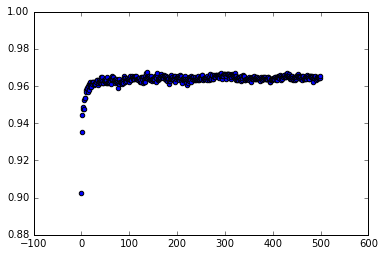

In [47]:
scatter(arange(len(percs)),percs)
#axis([70,100,0.95,0.97])

In [48]:
final = result.eval()
final

array([[  2.65624736e-06,   5.51162638e-11,   7.83802570e-10,
          8.67723025e-10,   9.99997342e-01],
       [  3.16494035e-17,   1.32525981e-18,   2.79829011e-09,
          9.99999991e-01,   6.49761880e-09],
       [  2.83983952e-07,   3.41552425e-11,   5.52019690e-09,
          9.82585330e-01,   1.74143802e-02],
       ..., 
       [  1.00000000e+00,   1.25255476e-23,   8.75010059e-28,
          7.05382549e-27,   3.88421002e-32],
       [  9.99999998e-01,   6.00710407e-17,   4.67632957e-17,
          2.23735897e-09,   1.46682642e-10],
       [  4.93925598e-09,   1.15504990e-09,   9.99996013e-01,
          1.59446014e-07,   3.82154478e-06]])

In [49]:
sum(final[0,:])

1.0

In [50]:
y_output = list([])
p_output = list([])
for i in arange(len(final)):
    my_list = final[i,:]
    max_index = my_list.argmax()
    p_output.append(my_list[max_index])
    y_output.append(max_index)
p_output = asarray(p_output)
mini = p_output.argmin()
print('{:.4f} index: {:d}'.format(p_output[mini],mini)) 

0.3894 index: 1339


In [51]:
len(y_output)

8137

In [52]:
import csv
with open('result22.csv', 'wb') as fp:
    a = csv.writer(fp, delimiter=',')
    a.writerow(('Id','y'))
    a.writerows(zip(ids,y_output))